# Big Data & Policing

**HW 3**

This Python Notebook includes solution to the Part 2 of the HW3.

Created by **Madhur Garg (20161228)**

# Part 2

**Libraries used in this notebook :**


In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import operator

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [2]:
FILENAME_DATASET = 'savry_2017.csv'

df = pd.read_csv(FILENAME_DATASET, sep='\t', index_col=False)

# Question 1

In [15]:
risk_eval_list = list(df['professional_risk_evaluation'])
sum_all_risk_list = list(df['sum_all_risk_items'])
relation = {}
for i in range(len(sum_all_risk_list)):
    if risk_eval_list[i] not in relation:
        relation[risk_eval_list[i]] = []
    else:
        relation[risk_eval_list[i]].append(sum_all_risk_list[i])
#print(relation)
avg_low = sum(relation['Low']) / len(relation['Low'])
avg_med = sum(relation['Moderate']) / len(relation['Moderate'])
avg_high = sum(relation['High']) / len(relation['High'])
relation['Low']=avg_low
relation['High']=avg_high
relation['Moderate']=avg_med

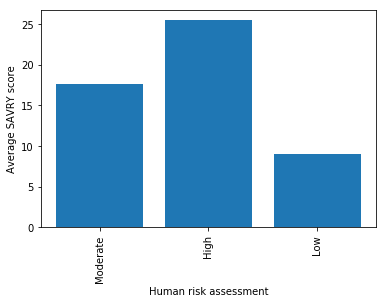

In [4]:
plt.bar(range(len(relation)), list(relation.values()), align='center')
plt.xticks(range(len(relation)), list(relation.keys()))
plt.xticks(rotation=90)
plt.xlabel('Human risk assessment')
plt.ylabel('Average SAVRY score')
plt.show()

**Although level of risk depends on other factors too but it can be seen that the average value of "sum_all_risk_items" is high for high "professional_risk_evaluation" and vice versa**

# Question 2

In [52]:
train, test = train_test_split(df, test_size=0.33)
risk_factor_columns = ["risk01_previous_violence", "risk02_history_nonviolent_offences",
                       "risk03_early_violence_before_14", "risk04_past_intervention_fail",
                       "risk05_self_harm_suicide_attempts", "risk06_violence_at_home",
                       "risk07_childhood_mistreatment", "risk08_criminal_parent_caregiver",
                       "risk09_early_separation_parents", "risk10_poor_school_achievement", 
                       "risk11_delinquency_peer_group", "risk12_rejection_peer_group",
                       "risk13_poor_stress_coping", "risk14_poor_parental_skills_parents",
                       "risk15_lack_of_personal_social_support", "risk16_marginalized_environment",
                       "risk17_negative_attitudes", "risk18_risk_taker_impulsive",
                       "risk19_drug_abuse", "risk20_anger_management_issues",
                       "risk21_low_empaty", "risk22_attention_deficit",
                       "risk23_poor_compliance_interventions", "risk24_low_commitment_school"]
demographic_columns = ["gender", "nationality", "main_crime_age", "criminal_records",
                       "main_crime_category", "main_crime_is_violent"]
protective_factor_columns = ["protective01_prosocial_activities", "protective02_strong_social_support",
                             "protective03_strong_link_prosocial_adult", "protective04_positive_attitude_interventions",
                             "protective05_high_commitment_school_or_work", "protective06_perseverant_personality"]


factors = demographic_columns + risk_factor_columns + protective_factor_columns
train_X = pd.get_dummies(train[factors])
train_y = train["recidivism"]

test_X = pd.get_dummies(test[factors])
test_y = test["recidivism"]
pd.get_dummies(train[factors])
model = LogisticRegression(solver='liblinear')
model.fit(train_X, train_y)
pred_logistic = model.predict(test_X)
offenses = list(test['main_crime_category'])

In [59]:
frequency = {}
for i in offenses:
    if i in frequency:
        frequency[i]+= 1
    else:
        frequency[i] = 1
#print(frequency)
for i in frequency:
    count = 0
    acc = 0
    for j in range(len(offenses)):
        if offenses[j] == i:
            if test_y.values[j] == pred_logistic[j]:
                count += 1
    acc = count / frequency[i]
    frequency[i] = acc
    
accuracy = sorted(frequency.items(), key=operator.itemgetter(1), reverse = True)
accuracy = dict(accuracy)
print(accuracy)

{'Others': 0.7333333333333333, 'Violent against property': 0.6385542168674698, 'Against persons': 0.6705882352941176, 'Nonviolent against property': 0.6626506024096386}


**Top 3 offenses predicted least accurately by the current Logistic Regression model :**

1. Violent against property: 0.638

2. Nonviolent against property: 0.662

3. Against persons: 0.670


# Question 3

In [60]:
train_X = pd.get_dummies(train[factors])
train_y = train["recidivism_severity"]

test_X = pd.get_dummies(test[factors])
test_y = test["recidivism_severity"]
#pd.get_dummies(train[risk_factor_columns])

model = LogisticRegression(multi_class='auto',solver='liblinear')
model.fit(train_X, train_y)
pred_logistic = model.predict(test_X)
count = 0
for i in range(len(pred_logistic)):
    if pred_logistic[i] == test_y.values[i]:
        count += 1
accuracy = count / len(pred_logistic)
predALL_y = model.predict_proba(test_X)[:,1]
print("Accuracy : ", accuracy)

Accuracy :  0.6654804270462633


In [68]:
def draw_roc_curve( ground_truth, predictions, pos_label=True):
    fpr, tpr, thresholds = roc_curve(ground_truth, predictions, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10,6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right", fontsize='x-large')
    plt.show()
    return roc_auc

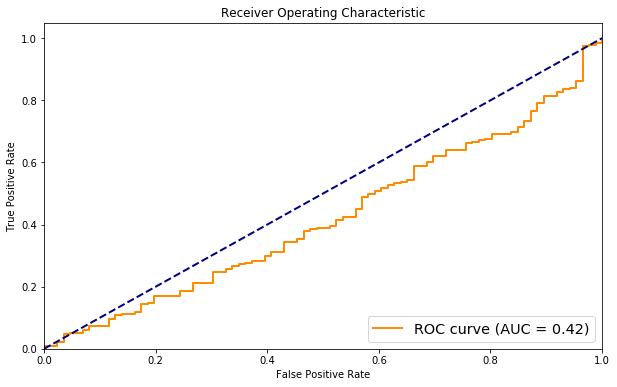

In [71]:
#for i in range(5):
test_severity = (test_y == 0)
_ = draw_roc_curve(test_severity, predALL_y)

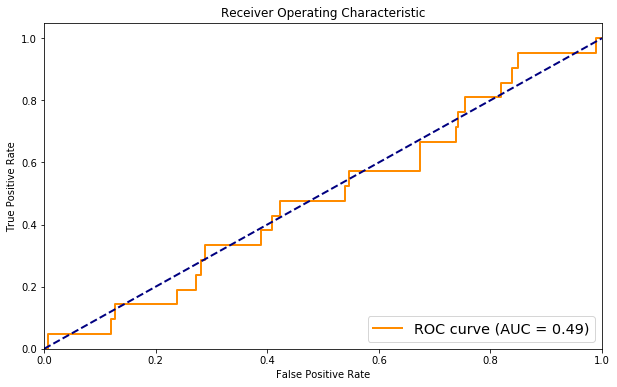

In [72]:
test_severity = (test_y == 1)
_ = draw_roc_curve(test_severity, predALL_y)

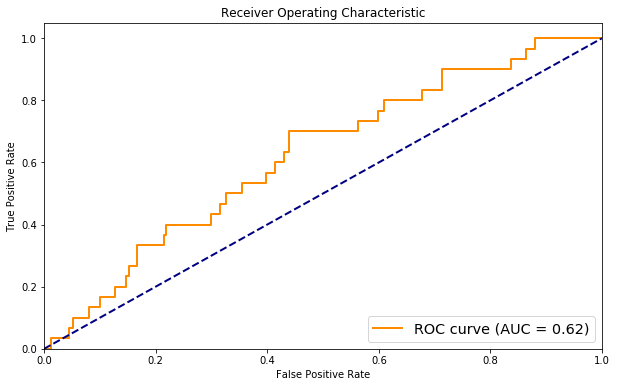

In [73]:
test_severity = (test_y == 2)
_ = draw_roc_curve(test_severity, predALL_y)

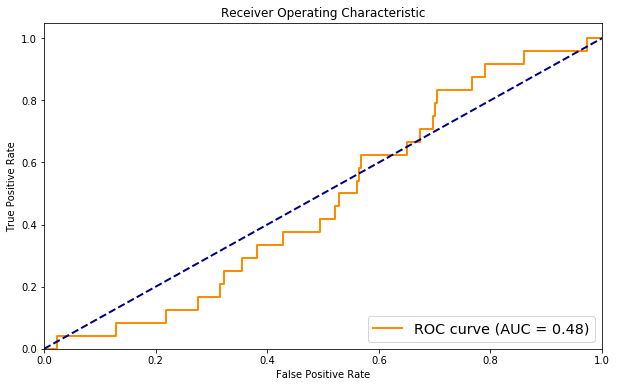

In [74]:
test_severity = (test_y == 3)
_ = draw_roc_curve(test_severity, predALL_y)

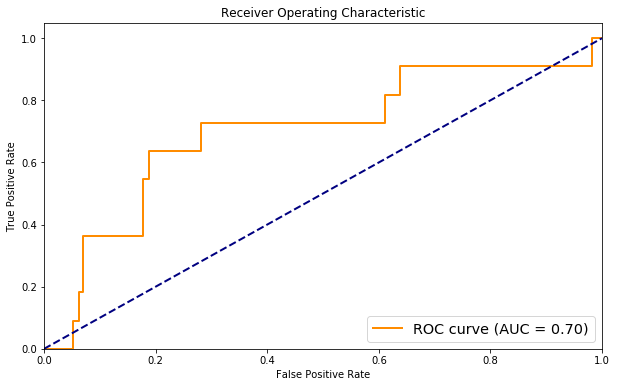

In [75]:
test_severity = (test_y == 4)
_ = draw_roc_curve(test_severity, predALL_y)

**On varying the severity value from 0 to 4 it can be seen that severity=0,1,3 has a bad ROC curve, severity=4 has a good ROC curve while severity=2 has accuracy similar to the prediction of recidivism**

# Question 4

In [116]:
train, test = train_test_split(df, test_size=0.33)
train_X = pd.get_dummies(train[factors])
train_y = train["recidivism_violence_first_offence"]

test_X = pd.get_dummies(test[factors])
test_y = test["recidivism_violence_first_offence"]

model = LogisticRegression(solver='liblinear', multi_class="auto")
model.fit(train_X, train_y)

pred = model.predict(test_X)
predALL_y = model.predict_proba(test_X)[:,1]

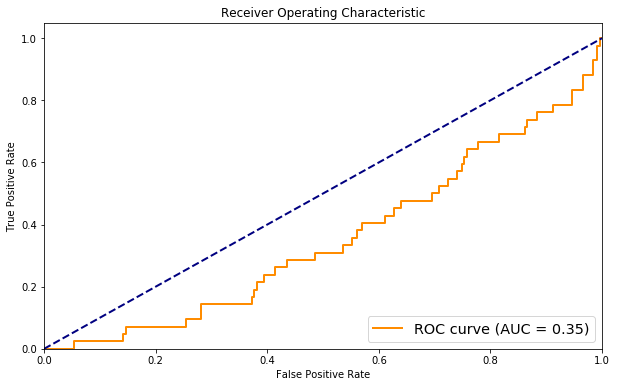

In [117]:
test_non_violence = (test_y == "No violent")
_ = draw_roc_curve(test_non_violence, predALL_y)

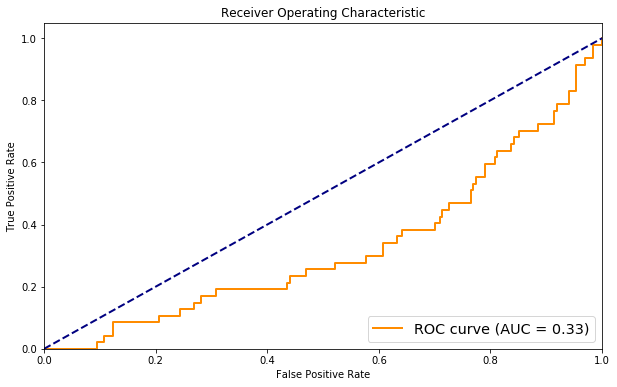

In [118]:
test_violence = (test_y == "Violent")
_ = draw_roc_curve(test_violence, predALL_y)

**Since AUC score is very less in both the cases and both the ROC curves shows a lot of False Positive. Thus, the predictions are less accurate compared to the existing model.**

# Question 5

# 1. Logistic Regression (Existing model)

In [135]:
train, test = train_test_split(df, test_size=0.33)
train_X = pd.get_dummies(train[factors])
train_y = train["recidivism"]

test_X = pd.get_dummies(test[factors])
test_y = test["recidivism"]

model = LogisticRegression(solver='liblinear')
model.fit(train_X, train_y)
predALL_y = model.predict_proba(test_X)[:,1]

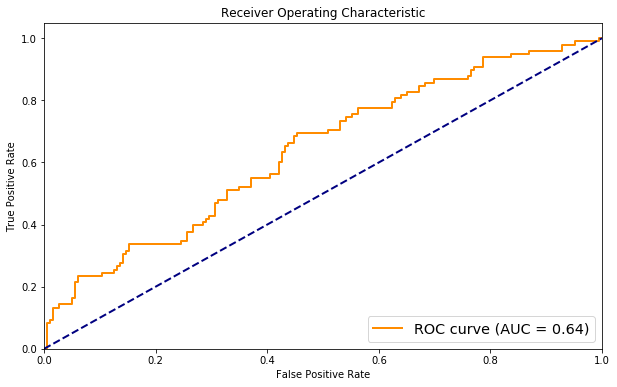

In [136]:
test_recidivism = (test_y == "Yes")
_ = draw_roc_curve(test_recidivism, predALL_y)

# 2. SVM

In [153]:
train, test = train_test_split(df, test_size=0.33)
train_X = pd.get_dummies(train[factors])
train_y = train["recidivism"]

test_X = pd.get_dummies(test[factors])
test_y = test["recidivism"]

model = SVC(kernel='linear',probability=True)  
model.fit(train_X, train_y)

predALL_y = model.predict_proba(test_X)[:,1]

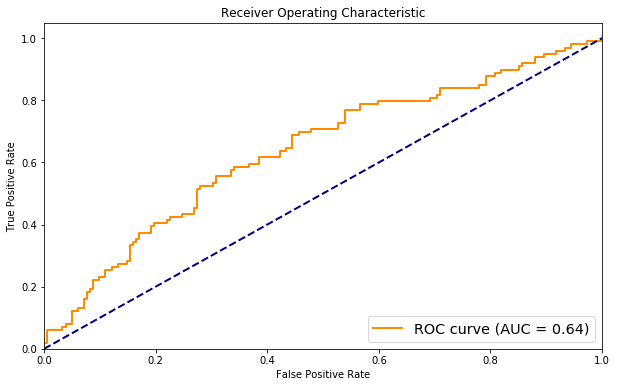

In [142]:
test_recidivism = (test_y == "Yes")
_ = draw_roc_curve(test_recidivism, predALL_y)

# 3. Neural Net

In [145]:
train, test = train_test_split(df, test_size=0.33)
train_X = pd.get_dummies(train[factors])
train_y = train["recidivism"]

test_X = pd.get_dummies(test[factors])
test_y = test["recidivism"]
model = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
model.fit(train_X, train_y)

predALL_y = model.predict_proba(test_X)[:,1]

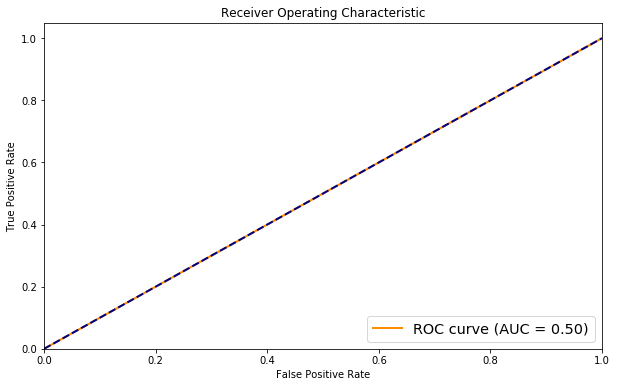

In [146]:
test_recidivism = (test_y == "Yes")
_ = draw_roc_curve(test_recidivism, predALL_y)

# 4. Decision Tree

In [151]:
train, test = train_test_split(df, test_size=0.33)
train_X = pd.get_dummies(train[factors])
train_y = train["recidivism"]

test_X = pd.get_dummies(test[factors])
test_y = test["recidivism"]
model = DecisionTreeClassifier(max_depth = 2)
model.fit(train_X, train_y)
predALL_y = model.predict_proba(test_X)[:,1]

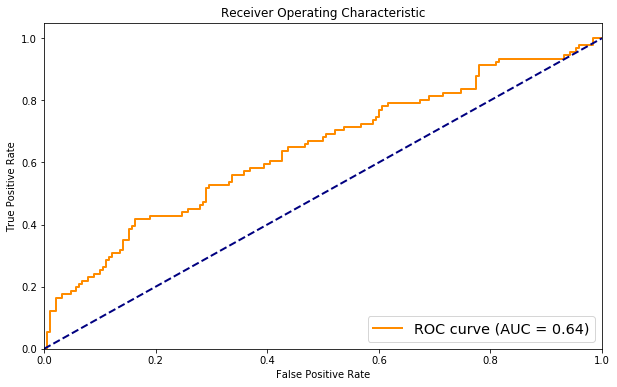

In [154]:
test_recidivism = (test_y == "Yes")
_ = draw_roc_curve(test_recidivism, predALL_y)

**The AUC scores of SVM, Logistic Regression (existing model) and Decision Tree are the same while that of Neural Net is less.**